In [1]:
%%capture
!pip install vaderSentiment
!pip install transformers
!pip install gdown

In [2]:
%%capture
import json

import os
from os import listdir
from os.path import isfile, join
from termcolor import colored
import pickle
from tqdm import tqdm
from statistics import mode
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
from collections import Counter
import zipfile
import gdown

from transformers import DistilBertForSequenceClassification,DistilBertTokenizer
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, TensorDataset,DataLoader
from sklearn.model_selection import train_test_split
import torch
from sklearn import metrics
from nltk.tokenize import word_tokenize,RegexpTokenizer
from nltk.corpus import sentiwordnet as swn

import pandas as pd

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

import seaborn

from matplotlib.colors import LinearSegmentedColormap

import urllib.request

from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('sentiwordnet')

In [3]:
# set runtime type on GPU (!), otherwise some code will run really slow
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print('Device available:', device)

Device available: cuda


# *A Sentiment Analysis of Spotify Podcasts*

#### NOTE: open this notebook in Google Colab, in order to have access to GPU power

#### NOTE: link to Github repo of this project: [https://github.com/bartvanvulpen/podcastDA](https://github.com/bartvanvulpen/podcastDA)





\begin{array}{c|c}
\text{Student Name}&\text{Student ID}\\\hline
\text{Bart van Vulpen}&11865210\\
\text{Juno Prent}&11915307\\
\text{Joris Hijstek}&11876980\\
\end{array}

## Contents


## 1 Introduction
A podcast is an audio file that contains a monologue, or a dialogue of one or more participants, which can be easily downloaded or streamed and listened to. The term podcast was first coined by the columnist and journalist Ben Hammersley in February 2004 as a way to combine the terms *'i-Pod'* and *'broadcasting'*. 
In 2005, the American company *Apple* released a new version of iTunes which provided a centralized platform for podcasts to be uploaded and downloaded from.


It is a traditional task in A.I. to predict the general tone of a sentence or sequence. For example, a company owner might attempt to filter positive reviews from negative reviews, but this can be taxing to do by hand. Thus, the owner could decide to have the reviews analyzed by an automated agent. The conventional name for an agent performing such a task is sentiment analysis.


Podcasts are interesting because they come in various shapes and sizes. Some are serious political talkshows while others are completely based on fiction. An interesting task would therefore be to detect the general mood throughout a podcast in order to learn more about the general composition of its contents.

Therefore, the main research question will be as follows: *What sentiment patterns can be found in podcasts episodes?* The question is split up into two subquestions: *What sentiment patterns can be found within podcast dialogues?* and *What sentiment patterns can be found in podcast dialogues in general?*.

Since sentiment analysis and sentiment prediction in podcasts has not been widely researched yet, several methods for this task will be explored first. Methods based on lexicons, unsupervised machine-learning and the state-of-the-art Transformer model will be examined to find the best performing architecture for predicting sentiment in podcast dialogues. Finally, the best performing method will be used to mine sentiment patterns within podcast dialogues and in podcast dialogues in general. The sentiment prediction task is described in Section 2. The background and related work of this project is described in Section 3. The properties of the dataset that is being used are assessed in Section 4. The several methods that will be examined are described in Section 5. Section 6 assesses the results, followed by the discussion, conclusion and future work in Section 7 and 8.

## 2 The Sentiment Prediction Task

A dialogue constist of mutiple utterances of each speaker participating in that dialogue. Each utterance in the dialogue has a certain degree of sentiment. These so called sentiment scores can then be used for sentiment analysis and sentiment pattern mining within and between dialogues.
Using the sentiment prediction task, these sentiment scores can be predicted for a utterance text. The task is relatively simple and set up below. \
\
Suppose $\mathbf{x}$ is a dialogue containing $N$ utterances:

\
\begin{equation}
   \mathbf{x}  = \{x_1, x_2, x_3, ..., x_N \}
\end{equation}

\
In the task, the sentiment score $s_i$ of each utterance $x_i$ is predicted using a given model M.
\
\
\begin{equation}
    s_i = \mathbf{M}(x)
\end{equation}
\
The sentiment score $s_i$ can then be classified in a label $y_i$, for example 'positive' or 'negative', based on the followinng condition:

\
\begin{equation}
    y_i = 
\begin{cases}
    negative,& \text{if } s_i\lt 0\\
    positive,              & \text{otherwise}
\end{cases}\\
\end{equation}
\
where $\mathbf{y}$ is the vector containing de sentiment labels for the dialogue $\mathbf{x}$.
\
\
\begin{equation}
   \mathbf{y}  = \{y_1, y_2, y_3, ..., y_N \}
\end{equation}
\
Label vector $\mathbf{y}$ can be used to get the sentiment of the total dialogue or can be used for deeper sentiment analysis, which can be seen in Section 5.5 and Section 6.2.


## 3 Related work

As mentioned before, there is no previous work which analyzed the sentiment in podcasts dialogues. However, in previous work, several methods for analyzing and predicting the sentiment in other kinds of texts have been developed over the years. For example an context-based classification method on reviews was developed by [(Turney, 2002)](https://www.aclweb.org/anthology/P02-1053.pdf). Turney determined sentiment scores, there referring to them as semantic orientations of phrases, which is any two-word pair with a specific predefined combination of part-of-speech tags (i.e. ‘adverb-adjective’ or ‘adjective-singular noun’) within online reviews by looking at the amount of times the words ‘excellent’ and ‘poor’ are in the vicinity of those phrases. Sentiment can also be predicted by using a lexicon of words and their associated sentiment score. Usually these scores lie between -10 and +10, where -10 is extremely negative and +10 is extremely positive. Using such a lexicon, the sentiment prediction task is made unsupervised as well. [(Taboada et al., 2011)](https://www.mitpressjournals.org/doi/pdf/10.1162/COLI_a_00049) have shown that such lexicon-based approaches are reliable. 
They developed The Semantic Orientation CALculator (SO-CAL) that was  consistent across several domains and on unseen data.
More statistical aproaches have been developer over the years as well. More statistical aproaches have been developer over the years as well. [(Dey et al., 2016)](https://arxiv.org/pdf/1610.09982.pdf) applied the sentiment prediction task on movie and hotel reviews using two supervised machine learning algorithms Naive Bayes' and K-Nearest Neighbour and compared both algorithm's performances. More complex machine-learning approaches are seen in the use of neural networks. [(Kumar et al., 2019)](https://arxiv.org/pdf/1911.12569.pdf) developed a method for sentiment prediction based on a attention-based Bi-directional LSTM architecture and a distributional Thesaurarus for external knowledge. This method outperformed the state-of-the-art systems on the SemEval 2016 and the Stance Sentiment Emotion Corpus on F-score. Besides LSTM networks,  Convolutional Neural Networks (CNNs) can also be used for the task, as [(Kim, 2014)](https://arxiv.org/pdf/1408.5882.pdf) showed by training a simple CNN on several tasks, including sentiment prediction on customer reviews, which showed state-of-the-art performance as well.

Nowadays, state-of-the-art pretrained models are can be finetuned for the sentiment prediction task as well. A good example is BERT (Bidirectional Encoder Representations from Transformers), a Transformer-based [(Vaswani et al., 2017)](https://arxiv.org/pdf/1706.03762.pdf) non-autoregressive language generation model that is very good at predicting the next word in a sequence. BERT is pre-trained on a large corpus of unlabelled text including more than 3,300 millionn words. The model that can be finetuned for several tasks like text summarization and machine translation, but also sentiment prediction. There exists even bigger and more complex models for sentiment prediction that are the current state-of-the-art for this task, like  SMART-RoBERTa Large [(Jiang et al., 2021)](https://arxiv.org/pdf/1911.03437v4.pdf), NB-weighted-BON + dv-cosine [(Thongtan & Phienthrakul, 2019)](https://www.aclweb.org/anthology/P19-2057.pdf) and XLNET [(Yang et al., 2020)](https://arxiv.org/pdf/1906.08237v2.pdf).

## 4 Dataset




### 4.1 Spotify Podcast Dataset
For analyzing the sentiment within and between podcasts, the Spotify Podcast Dataset 
[(Clifton et al., 2020)](https://arxiv.org/pdf/2004.04270.pdf) was used. This dataset contains over 100,000 randomly sampled podcast episodes. Each episode has an audio file containing the podcast itself. Also, a transcript was made for each episode using Google's Speech-To-Text model, with a word error rate of 18.1%. Each transcript also contains speaker tags that indicate the speaker who is actually talking. Finally, some metadata was provided containing information about the podcast itself (e.g. language and name). 
In total, the dataset contains more than 2TB of audio files and more than 100GB of transcript files in JSON format. 

### 4.2 Data Preprocessing
In this project, only the transcripts were used. Due to lack of computational resources, a subset containing more than 40GB of transcripts was taken. Each JSON file containing the transcript of one episode was processed into a Pandas Dataframe containing each utterance in the dialogue with the corresponding speaker tag. Also, an empty sentiment column called *sentiment_score* was added to the dataframe. Below an example of the data structure is shown.



In [4]:
urllib.request.urlretrieve('https://drive.google.com/uc?id=1GDX2SxEma1ysjWMqqyQugUFXAYdmut7N&export=download', 'dialogue_example.csv')
# load binary validation dataset
example_df = pd.read_csv('dialogue_example.csv', sep='\t').drop('Unnamed: 0', axis=1)
example_df.head(5)

,speaker_tag,text,sentiment_score
0,3,The subconscious mind creates the personality....,NaN
1,1,Hi everyone. This is the Tuda and you are in s...,NaN
2,3,Very well actually is enjoying your London. It...,NaN
3,1,Thank you so much for coming. I'm looking forw...,NaN
4,3,"Yes, definitely. The interesting thing is that...",NaN


Each DataFrame was exported to a .CSV file. Dialogues with less than five utterances were filtered out. Using the metadata non-English episodes were filtered out as well. This finally resulted in a dataset of 37,610 dialogues, containing 3,014,600 utterances in total. This dataset was split up into three subsets, so each method had it's own dataset to work with.



### 4.3 Labeling Data
In order to evaluate each examined method, it was necessary to have a small labeled dataset. Thus, the sentiment of each utterance in several podcast dialogue transcripts were labeled as either negative (0) or positive (1). Since the utterances were automatically generated with a word error rate of 18.1% and dialogue utterances can get really long in podcasts, we decided to not take *neutral* sentiment into account. Taking the neutral label into account as well would make the sentiment prediction task much more difficult and less accurate.

In total, 4304 utterances in 54 podcast dialogues were labeled. From these labeled dialogues, a training and validation set was generated by taking a random sample of their utterances.The validation set was used for evaluation of all methods but the Neighbourhood-based Method, as that requires the context of an utterance to score it. There, entire labeled transcripts were randomly picked to train and validate with. The training set was used for the DistilBert sentiment classifier only.


## 5 Methods


### 5.1 Lexicon-based Sentiment Prediction

The first method that was examined made us of lexicons to predict the sentiment of dialogue utterances. In this relatively simple method, two approaches were examined, the first by using SentiWordNet 3.0 
[(Baccianella et al., 2010)](http://www.lrec-conf.org/proceedings/lrec2010/pdf/769_Paper.pdf) and the other by using a rule- and lexicon-based sentiment analyzer called VADER.

#### 5.1.1 SentiWordNet
In this approach, the lexical resource called SentiWordNet was used. This lexicon is made for opinion mining and sentiment analysis and is based on the famous WordNet [(George A. Miller (1995)](https://www.aclweb.org/anthology/H94-1111.pdf). For each synset (a set of synonyms that share a common meaning) in WordNet, a positivity score, negativity score and objectivity score is assigned by SentiWordNet, so it simply is a large corpus containing POS-tagged English words along with their sentiment scores. 
The lexicon is built on a combination of a quantitive analysis of the glosses associated to synsets in WordNet and a machine learning-based synset classification using the resulting vectoral term representations of the synset glosses [(Esuli & Sebastiani, 2006)](http://nmis.isti.cnr.it/sebastiani/Publications/LREC06.pdf).

For predicting the sentiments in a podcast dialogue, each utterance was first tokenized into tokens (or words). Subsequently, the POS-tags for each token were obtained using NLTK's POS tagger. Then, each token was lemmatized and the synset for that token was obtained using its lemma and POS-tag. Thereafter, he sentiment of each token was calculated using the  formula below, where S corresponds items in the token's synset, N to the number of items in the synset and $p\_score$ and $n\_score$ to the positivity score and negativity score respectively.
\
\
\begin{equation}
  \text{sentiment score} = \frac{1}{N}\sum_{s \in S}^{N}s_{p\_score} - s_{n\_score}
\end{equation} \\

Finally, in order to calculate the total sentiment of the utterance, the average score of all tokens was taken. The total sentiment was classified as $0$ (negative) or $1$ (positive) using the condition in described in Section 2.

In the cell below the Python function for predicting the sentiment label of a podcast dialogue utterance is shown.

In [5]:
def SentiWordNet_sentiment(utterance):
    """
    Returns the sentiment label (0 or 1) for a podcast utterance with tagged tokens 
    using SentiWordNet
    """
    # tokenize utterance
    lemmatizer = nltk.WordNetLemmatizer()
    tokens = nltk.word_tokenize(utterance)
    
    # POS tag utterance
    tagged_tokens = nltk.pos_tag(tokens)
    
    # assign sentiment score using SentiWordNet, including synonyms
    tokens_sentiment_scores = []
    for token in tagged_tokens:
        tag = ''
        lemma = lemmatizer.lemmatize(token[0])
        if token[1].startswith('N'):
            tag = 'n'
        elif token[1].startswith('J'):
            tag = 'a'
        elif token[1].startswith('V'):
            tag = 'v'
        elif token[1].startswith('R'):
            tag = 'r'
        if tag != '':
            # also get sentiments for synonyms
            synonyms = list(swn.senti_synsets(lemma, tag)) 
            token_sentiment = 0
            if len(synonyms) > 0:
                for synonym in synonyms:
                    token_sentiment += synonym.pos_score() - synonym.neg_score()
                tokens_sentiment_scores.append(token_sentiment/len(synonyms))      
   
    if tokens_sentiment_scores != []:
        sentiment_score = sum(tokens_sentiment_scores)/len(tokens_sentiment_scores) 

        if sentiment_score >= 0:
            return 1
        elif sentiment_score < 0:
            return 0
    else:   
        return 1

#### 5.1.2 VADER Sentiment
VADER stands for **V**alence **A**ware **D**ictionary and s**E**ntiment **R**easoner. It is a lexicon and rule-based tool for sentiment-analysis, especially for social media texts [(Hutto & Gilbert, 2014)](https://www.aaai.org/ocs/index.php/ICWSM/ICWSM14/paper/download/8109/8122/). Vader is based on quantitative and qualitative methods. They first labeled a large lexicon of words with their corresponding sentiment. Subsequently, they combined this lexicon with five rules that represent syntactical and grammatical conventions for expressing sentiment. This makes VADER intelligent enough to understand that “did not love”  is negative and while “love" is a word with high positive sentiment. VADER is also able to understand  capitalisation and punctuation. For example, ‘GREAT’ and ‘amazing!’ have a higher positive sentiment word than ‘great’ and ‘amazing’.

In this approach, the compound (positive, negative and neutral combined) VADER polarity score is used to calculate the sentiment score of an utterance. Following the same condition as the SentiWordNet approach this score is then transformed into a sentiment label.

In [6]:
def VADER_sentiment(utterance):
    """
    Returns the VADER-based sentiment label (0 or 1) of a dialogue utterance 
    using the compound sentiment score.
    """
    analyser = SentimentIntensityAnalyzer()
    score = analyser.polarity_scores(utterance)['compound']   
    if score >= 0:
        return 1
    elif score < 0:
        return 0

### 5.2 Neighbourhood-based Method

The second method was based on the previously mentioned works of [Turney  (2002)](https://www.aclweb.org/anthology/P02-1053.pdf), in which the sentiment scores of online reviews are calculated by looking at the neighbouring words of certain phrases within those reviews. For lack of a better term, this method will be referred to as Neighbourhood-based Method throughout this paper.  For each of those phrases, the amount of occurrences of the words ‘excellent’ and ‘poor’ in the previous and next 10 words are counted, which is derived from the way the AltaVista seach engine’s NEAR operator works. The final semantic orientation of a phrase is then defined as: 

\begin{equation}
SO = \log(\frac{hits(\text{phrase NEAR 'excellent'})hits(\text{'poor'})}{hits(\text{phrase NEAR} 'poor')hits(\text{'excellent'})})
\end{equation} \\

To determine whether any two-word pair was a phrase, the following function was used:





In [7]:
# Determines whether two words are considered a phrase according to 'Thumbs Up or Thumbs Down? 
# Semantic Orientation Applied to Unsupervised Classification of Reviews' by Peter D. Turney, 2002.

def is_phrase(word_index, words):
    first_tag = nltk.pos_tag([words[word_index]])[0][1]
    second_tag = nltk.pos_tag([words[word_index + 1]])[0][1]
    # Considers the tag of the word after the potential phrase, if there is one.
    try:
        third_tag = nltk.pos_tag([words[word_index + 2]])[0][1]
    except IndexError:
        pass
    
    if first_tag == 'JJ':
        if second_tag in ['NN', 'NNS']:
            return True
        elif second_tag == 'JJ':
            try:
                if third_tag not in ['NN', 'NNS']:
                    return True
            except NameError:
                return True
    elif first_tag in ['RB', 'RBR', 'RBS']:
        if second_tag == 'JJ':
            try:
                if third_tag not in ['NN', 'NNS']:
                    return True
            except NameError:
                return True
        elif second_tag in ['VB', 'VBD', 'VBN', 'VBG']:
            return True
    elif first_tag in ['NN', 'NNS']:
        if second_tag == 'JJ':
            try:
                if third_tag not in ['NN', 'NNS']:
                    return True
            except NameError:
                return True
    # If no correct combination is found, the word pair is not a phrase
    return False

Applying a method for sentiment analysis that was created for online reviews and applying it to podcast transcripts (or any written dialogue for that matter) quickly presented several needs for alterations. Firstly, the range 10 previous and next words was too low. This value, from now on referred to as the NEAR value, was always at least 50 during the evaluation. Secondly, the words ‘excellent’ and ‘poor’ proved to be far too scarcely used to get accurate scores. To better capture the broad range of vocabulary that is used by different people across many podcasts, two lists – one with positive words, one with negative ones – were used instead. These were each comprised of the most frequent adjectives across the dataset and some more frequent sentiment indicating words such as ‘yes’ and ‘no’. This lead to the following lists:
<br/>
<br/>
\begin{equation}
\\
\text{Positive words} = [\text{'good', 'great', 'nice', 'happy', 'easy', 'yes', 'yeah', 'love', 'big', 'right', 'awesome', 'thank', 'thanks'}] \\
\text{Negative words} = [\text{'bad', 'horrible', 'tough', 'sad', 'hard', 'no', 'shit', 'hate', 'little', 'wrong', 'stupid', 'sorry'}]
\end{equation} \\

To stay in line with the utterance scoring of the other methods, each utterance got assigned its sentiment score by taking the average of the scores of all phrases within that utterance. Utterances that don’t contain any phrases are assigned a score that is based on the average of the scores of the nearest previous and next utterances that do already have a sentiment score. As the scores had to be between -1 and 1, the score of each utterance in a transcript was normalized by dividing by the highest absolute value among them. The final change from the method of Turney is that a phrase is given a score if it has at least two positive and two negative words near it, instead of at least four words each. All this lead to the following functions to assign scores to utterances:

In [8]:
# For each utterance that wasn't assigned a score (either by not containing a phrase at all
# or by not containing any with enough positive and negative words surrounding it), an average
# of the scores of the nearest previous and next utterance is used

def fill_nans(df):
    replacements = df['predicted_score'].copy()
    for i in range(len(df)):
        if np.isnan(df['predicted_score'][i]):
            new_values = []
            j = i-1
            while j >= 0:
                if not np.isnan(df['predicted_score'][j]):
                    new_values.append(1 / ((i - j) + 1) * df['predicted_score'][j])
                    break
                j -= 1
            j = i+1
            while j < len(df):
                if not np.isnan(df['predicted_score'][j]):
                    new_values.append(1 / ((j - i) + 1) * df['predicted_score'][j])
                    break
                j += 1
            if new_values:
                replacements[i] = np.mean(new_values)
            else:
                replacements[i] = 1
    df['predicted_score'] = replacements
    return df

In [9]:
# Assigns a sentiment score between 0 and 1 for each utterance in the dataframe

def add_scores(df, NEAR, pos_words, neg_words):
    # Considers the previous and upcoming NEAR words surrounding the phrase
    utt_lens = []
    utt_scores = []
    all_words = []
    utt_idx = 0
    df['predicted_score'] = np.nan
    
    
    # Gets the length of each utterance so the semantic scores are assigned to the
    # correct utterance, also a list with all words
    for utt in df.text:
        utt_lens.append(len([w for w in nltk.word_tokenize(utt) if w not in ['.', ',', '?', '!', '\'']]))
        all_words += [w for w in nltk.word_tokenize(utt) if w not in ['.', ',', '?', '!', '\'']]

    # Checks how many positive and negative words the enitre text contains
    word_counter = Counter([w.lower() for w in all_words])
    pos_hits = sum([word_counter[p] for p in pos_words]) + 0.01
    neg_hits = sum([word_counter[n] for n in neg_words]) + 0.01
    
    for i in range(len(all_words) - 1):
        # Keeps track of which utterance every possible phrase is in
        if i >= sum(utt_lens[:utt_idx+1]) or i == len(all_words) - 2:
            # When going to a new utterance, assigns the mean of the semantic scores
            # of each phrase in the previous utterance as the score of that utterance
            if utt_scores:
                df['predicted_score'][utt_idx] = np.mean(utt_scores)
            utt_idx += 1
            utt_scores = []
        # Creates list of neighbouring words of each phrase found, accounting for edge cases
        if is_phrase(i, all_words):
            neighbourhood = []
            if NEAR > i:
                neighbourhood += all_words[:i]
            else:
                neighbourhood += all_words[i-NEAR:i]
            if i != len(all_words) - 2:
                try:
                    neighbourhood += all_words[i+2:i+2+NEAR]
                except IndexError:
                    neighbourhood += all_words[i+2:len(words)]
            # Counts the amount of positive and negative words in the neighbourhood
            neighbourhood_counter = Counter([w.lower() for w in neighbourhood])
            pos_neigh_hits = sum([neighbourhood_counter[p] for p in pos_words]) + 0.01
            neg_neigh_hits = sum([neighbourhood_counter[n] for n in neg_words]) + 0.01
            # Applies the function from the paper to calculate the phrase's score
            if pos_neigh_hits > 2 and neg_neigh_hits > 2:
                score = np.log((pos_neigh_hits * neg_hits)/ (neg_neigh_hits * pos_hits))
                utt_scores.append(score)
                

    # Normalizes each predicted sentiment score
    df = fill_nans(df)
    abs_max = max([max(df['predicted_score']), -min(df['predicted_score'])])
    if abs_max:
        df.loc[:, 'predicted_score'] += abs_max
        df.loc[:, 'predicted_score'] /= (2*abs_max)
    df.loc[df.predicted_score >= 0.5, 'predicted_score'] = 1.0
    df.loc[df.predicted_score < 0.5, 'predicted_score'] = 0.0
        

    return df

### 5.3 Unsupervised Sentiment Prediction Using Word2Vec, K-means, and TF-IDF
The general idea behind sentiment analysis is detecting a tone in a segment of speech. However, this can be quite difficult to achieve if the training data is not labeled. The method used below utilizes TF-IDF [(Spärck Jones, 1972)](https://pdfs.semanticscholar.org/4f09/e6ec1b7d4390d23881852fd7240994abeb58.pdf?source=post_page---------------------------), Word2Vec [(Mikolov et al., 2013)](https://arxiv.org/pdf/1310.4546.pdf) and K-means[(J MacQueen, 1967)](https://www.cs.cmu.edu/~bhiksha/courses/mlsp.fall2010/class14/macqueen.pdf).

First, the datasets that will be used for training and evaluation are loaded.


In [10]:
# Function that removes punctuation, lowercases everything (to normalize), tokenizes, and converts the labels to int
def clean_data(df):
    tokenizer = RegexpTokenizer(r'\w+')
    df['text'] = df['text'].str.lower()
    df['text_tokenized'] = df['text'].apply(tokenizer.tokenize)
    return df

In [11]:
# download training dataset
url = 'https://drive.google.com/uc?id=173Nk1f8wmK9MsmKTdbOdXA6fKEjD__8J'
output = 'training_set.csv'
gdown.download(url, output, quiet=False)
df_train = pd.read_csv('training_set.csv', sep='\t')

# Normalize and clean text
df_train = clean_data(df_train)
text = df_train['text_tokenized'].values

Downloading...
From: https://drive.google.com/uc?id=173Nk1f8wmK9MsmKTdbOdXA6fKEjD__8J
To: /content/training_set.csv
100%|██████████| 1.24M/1.24M [00:00<00:00, 124MB/s]




Using gensim's Phrases and Phraser modules, the most common phrases can be extraced from the corpus. The parameter *min_count* can be utilized to create a lower boundry for the minimal frequency of terms in the corpus. This means that higher values of *min_count* result in a decreased number of terms in the final corpus.


In [12]:
optimized_terms = Phraser(Phrases(text, min_count=2))
text_final = optimized_terms[text]

#### 5.3.1 Word2Vec
First, in order to model the relationship between different terms in the dataset, Word2Vec [(Mikolov et al., 2013)](https://arxiv.org/pdf/1310.4546.pdf)is used. Each words is assigned a vector that represents its compositionality compared to other words in the corpus. For example, comparing the words *'King'* and *'Queen'* trained in cooperation with a large dataset might yield vectors that are roughly interpretable as

\begin{equation}
    \text{King} = \text{Male} + \text{Royal}\\
    \text{Queen} = \text{King} - \text{Male} + \text{Female}
\end{equation}

Considering the size of the corpus and previous tests, a 300-dimensional Word2Vec model is built and trained using the corpus with added bigrams.

In [13]:
modelw2v = Word2Vec(text_final,size=300)
modelw2v.build_vocab(text_final, update=True)
modelw2v.train(text_final, total_examples=modelw2v.corpus_count, epochs=30)

(4174269, 6944010)

In [14]:
word_vectors = modelw2v.wv

#### 5.3.2 K-means Clustering
Using Word2Vec, each word has been given a vector. These vectors can be utilized with the K-means algorithm in order to find clusters of words that are closer together. These clusters then contain words that are distinguishable as more or less positive or negative.

In [15]:
model = KMeans(n_clusters=2, max_iter=10000, random_state=True, n_init=1000).fit(X=word_vectors.vectors.astype('double'))

After training the K-means model, the obtained clusters have to be manually labeled according to which cluster is deemed more positive, and thus, which cluster is deemed more negative.

In [16]:
print(word_vectors.similar_by_vector(model.cluster_centers_[0], topn=10, restrict_vocab=None))
print(word_vectors.similar_by_vector(model.cluster_centers_[1], topn=10, restrict_vocab=None))

[('bethenny', 0.6760615110397339), ('guilty', 0.6636659502983093), ('loyal', 0.65386962890625), ('uncomfortable', 0.6520451307296753), ('say_anything', 0.6492599844932556), ('focused', 0.6368128657341003), ('cowboy_hat', 0.629563570022583), ('unbelievable', 0.6276184320449829), ('frank', 0.6256113052368164), ('too_young', 0.6254780292510986)]
[('combat', 0.8258557319641113), ('free_agency', 0.810555636882782), ('team_rules', 0.808019757270813), ('rate', 0.8011363744735718), ('previous', 0.800624668598175), ('creatures', 0.7997298240661621), ('chompers', 0.7956754565238953), ('kicks', 0.7945824861526489), ('our_community', 0.7945696115493774), ('uk', 0.7945586442947388)]


Then, as the second and final manual step, the index of the more positive cluster must be entered, according to the perceived assignment of clusters.

In [17]:
# Enter the index of the positive cluster
positive_cluster_index = 0

positive_cluster_center = model.cluster_centers_[positive_cluster_index]
negative_cluster_center = model.cluster_centers_[1-positive_cluster_index]

Next, in order to create a metric that can help with classifying in the final step, the words are vectorized and assigned to a cluster. The distance, or of each word to their respective cluster is then connected to each word. Finally, a coëfficient is calculated by multiplying this distance to the respective cluster value.

In [18]:
def create_df_dict():

    # Create vectors for each word
    metrics_df = pd.DataFrame(word_vectors.vocab.keys())
    metrics_df.columns = ['words']

    # Assign words to a cluster using Sklearn's predict
    metrics_df['vectors'] = metrics_df['words'].apply(lambda x: word_vectors[f'{x}'])
    metrics_df['cluster'] = metrics_df['vectors'].apply(lambda x: model.predict([np.array(x)]))

    # Unpack the values from list
    metrics_df['cluster'] = metrics_df['cluster'].apply(lambda x: x[0])

    # Assign words to cluster
    metrics_df['cluster_value'] = [1 if i==positive_cluster_index else -1 for i in metrics_df['cluster']]

    # Assign the inverse distance to the closest cluster to each word
    metrics_df['distance'] = metrics_df.apply(lambda x: 1/(model.transform([x['vectors']]).min()), axis=1)

    # Calculate the sentiment coefficient
    metrics_df['sentiment_coeff'] = metrics_df['distance'] * metrics_df['cluster_value']

    sentiment_dict = dict(zip(metrics_df['words'].values, metrics_df['sentiment_coeff'].values))

    return metrics_df, sentiment_dict

#### 5.3.4 The Prediction Phase
After each sequence has been transformed into its corresponding TF-IDF sequence, the prediction can be obtained by calculating the dot product of the TF-IDF scores and the sentiment coefficient, which is the overall sentiment multiplied by the predicted sentiment cluster, which has a value of either -1 (negative sentiment) or 1 (positive sentiment):

\begin{equation}
\text{Sentiment prediction = TF-IDF score}\bullet(\text{closeness}_{min}\cdot \text{cluster value})
\end{equation}

which is then transformed using the condition described in section 2.

Now that the model is completed, the results phase contains more code for calculations performed on the validation dataset. Finally, these labels can be compared to the labeled data, which is demonstrated in section 6.1.3.

### 5.4 DistilBERT Sentiment Prediction



In this Deep Learning-based method, a smaller and faster version of the previously mentioned BERT model was used. This model is called DistilBERT and is 40% smaller and 60% faster than BERT, all while retaining more than 95% of BERT’s performance [(Sanh et al., 2019)](https://arxiv.org/pdf/1910.01108). DistilBERT is pretrained and was finetuned on the labeled training dataset (mentioned in Section 4) for the sentiment prediction task of podcast dialogues. Finally, the model was evaluated on the labeled validation set. During this evaluation, parameter-tuning was done with the learning-rate and the weights of the model with the best metrics were saved. The training and inference code for this model can be found on the [Github repository](https://github.com/bartvanvulpen/podcastDA) of this project, under `BERT_training.ipnyb` and `BERT_inference.ipynb` respectively. 




### 5.5 Mining Sentiment Patterns
From the previously described methods, the best performing method in terms of accuracy, recall, precision and F1-score was applied on the dataset containing 36,318 podcast dialogue with 3,010,296 utterances. The outputs (sentiment labels per utterance per dialogue) were used to mine and analyze sentiment paterns in podcast dialogues.

First, some general sentiment statistics were mined from the output produced by the best performing model. These statistic included the number of positive and negative utterances in podcasts in total as well as the number of positive labeled and negative labeled podcast episodes.
Secondly, sentiment patterns within podcast dialogues were mined. This consists of finding the most common sentiment patterns (e.g. '+++' or '+-+') and longest patterns within podcast dialogues. Also, based on the output sentiment labels, the gradients of the sentiment within some podcast dialogues were visualized. Finally, an aggregration of the sentiment gradients of all podcast episodes was done to visualize the total sentiment gradient of podcasts in general. In order to be able to aggregrate, the output data first needed to be scaled in such way that each array of utterance labels for each dialogue had the same length. The function that scaled the data was based on percentages of segmentations within such an array of utterance labels and is declared below. 





In [19]:
def segment_seqs(x):
    """
    This function segments a list into sublists where each
    sublist corresponds to a repetitive sequence of 0's or 1's
    in the given list x
    """
    if not x:
        return []
    result = [[x[0]]]
    j = 0
    for i in range(1, len(x)):
        if x[i] != x[i - 1]:
            result.append([])
            j += 1
        result[j].append(x[i])
        
    return result

def scale_data(sentiment_data):
    """
    Scale a list with sentiments (0's and 1's) to the max_length of the data
    in order to aggregrate the data.
    """
    max_len = max([len(i) for i in sentiment_data])
    scaled_data = np.zeros((len(sentiment_data), max_len))
    
    for index, x in tqdm(enumerate(sentiment_data)):
        old_len = len(x)
        segmented_x = segment_seqs(x)

        scaled_x = []
        for item in segmented_x:

            bit = item[0]
            percentage = len(item)/old_len
        
            n = int(np.round(max_len * percentage))
            
            for s in n*[bit]:
                scaled_x.append(s)
  
        if len(scaled_x) == max_len:
            scaled_data[index] = scaled_x

        else:
            # do padding before and after, to make length equal to max length of the data
            difference = max_len - len(scaled_x)
    
            if difference > 0:
  
                pad_before = difference // 2
                pad_after = (difference // 2) + (difference % 2)

                scaled_x = pad_before * [scaled_x[0]] + scaled_x + pad_after * [scaled_x[-1]]

                if len(scaled_x) == max_len:
                    scaled_data[index] = scaled_x

                else:  
                    raise Exception("Length of scaled list not equal to max length of the data") 
                
            elif difference < 0: 
                
                diff = abs(difference)
                remove_before = diff // 2
                remove_after = (diff // 2) + (diff % 2)

                scaled_x = scaled_x[remove_before:len(scaled_x)-remove_after]

                if len(scaled_x) == max_len:
                    scaled_data[index] = scaled_x

                else:
                    raise Exception("Length of scaled list not equal to max length of the data") 
             
    return scaled_data

## 6 Results

### 6.1 Metrics
First we download the validation set used to calculate the validation metrics. For validation of the Neighbourhood-based Method, the full labeled .csv-files were downloaded.


In [20]:
# load validation set for lexicon-based, Word2Vec + K-means + TD-IDF and BERT methods
urllib.request.urlretrieve('https://drive.google.com/uc?id=1Xf3LGvIBYA7YqUFy473qowk4V4MT3t4g&export=download', 'validation_set.csv')
val_df = pd.read_csv('validation_set.csv', sep='\t')
val_df['sentiment_score'].value_counts()

1.0    887
0.0    405
Name: sentiment_score, dtype: int64

In [21]:
# Load validation set for neighbourhood-based method
gdown.download('https://drive.google.com/uc?id=1aqE8yS7Lf8GfljmFEuW5pd3i5S2raW1B', 'separate_csv_files.zip', quiet=False)
with zipfile.ZipFile('separate_csv_files.zip', 'r') as zip_ref:
    zip_ref.extractall('')

Downloading...
From: https://drive.google.com/uc?id=1aqE8yS7Lf8GfljmFEuW5pd3i5S2raW1B
To: /content/separate_csv_files.zip
100%|██████████| 671k/671k [00:00<00:00, 94.7MB/s]


#### 6.1.1 Lexicon based method

The SentiWordNet approach achieved a total accuracy of 68%, along with a decent recall on positive labels. However, it performed bad in terms of recall and precision on negative labels.



In [22]:
# calculate metrics for SentiWordNet method
target_labels = val_df['sentiment_score'].values
predicted_labels = []
for sample in tqdm(val_df['text']):
    predicted_sentiment = SentiWordNet_sentiment(sample)
    predicted_labels.append(predicted_sentiment)

predicted_labels = np.array(predicted_labels)  
print
print('\n\n', classification_report(target_labels, predicted_labels))

100%|██████████| 1292/1292 [00:11<00:00, 111.53it/s]



               precision    recall  f1-score   support

         0.0       0.48      0.42      0.45       405
         1.0       0.75      0.80      0.77       887

    accuracy                           0.68      1292
   macro avg       0.62      0.61      0.61      1292
weighted avg       0.67      0.68      0.67      1292



The VADER sentiment classifier achieved better performance in terms of accuracy and F1-score (73% and 83% respectively) on positive labels than the SentiWordNet approach. However, VADER performed much worse in terms of recall on negative labels, only 26%.


In [23]:
predicted_labels = []
for sample in tqdm(val_df['text']):
    predicted_sentiment = VADER_sentiment(sample)
    predicted_labels.append(predicted_sentiment)

predicted_labels = np.array(predicted_labels)  
print('\n\n', classification_report(target_labels, predicted_labels))

100%|██████████| 1292/1292 [00:14<00:00, 92.07it/s] 



               precision    recall  f1-score   support

         0.0       0.68      0.26      0.38       405
         1.0       0.74      0.94      0.83       887

    accuracy                           0.73      1292
   macro avg       0.71      0.60      0.60      1292
weighted avg       0.72      0.73      0.69      1292



#### 6.1.2 Neighbourhood-based Method

To test the performance of the Neighbourhood-based Method, it was important to first find the most optimal parameter values for the NEAR value and the lists of positive and negative words that should be looked for. To do this, the following performance testing and parameter optimization functions were used:




In [24]:
# Returns a classification report that shows the performance of the predicted sentiment scores
# when compared to the actual sentiment scores. Takes n randomly chosen podcast episodes with at
# least min_len utterances from a folder with labeled csvs, or all of them if n is too large
# and outputs the classification report.

def compare_scores(labeled_folder, NEAR, pos_words, neg_words, n, min_len, output_dict):
    # Hides warnings
    pd.options.mode.chained_assignment = None
    
    # Gets all file names within the folder
    filenames = [f for f in listdir(labeled_folder) if isfile(join(labeled_folder, f))]
    np.random.shuffle(filenames)
    dfs = []
    c = 0
    # Looks for up to n podcast episodes with at least min_len utterances
    for filename in filenames:
        df = pd.read_csv(labeled_folder + '/' + filename, sep='\t')
        if len(df) >= min_len:
            dfs.append(df)
            c += 1
            if c == n:
                break
        
    # Returns the classification report for the performance of the classification of the 
    # sentiments.
    if len(dfs) == 1:
        df = add_scores(df, NEAR, pos_words, neg_words)
        return classification_report(list(df.sentiment_score.values), 
                                       list(df.predicted_score.values), zero_division=0, 
                                     output_dict=output_dict)
    total_scores = []
    total_predicted = []
    for df in dfs:
        df = add_scores(df, NEAR, pos_words, neg_words)
        total_scores += list(df.sentiment_score.values)
        total_predicted += list(df.predicted_score.values)
    return classification_report(total_scores, total_predicted, zero_division=0, 
                                 output_dict=output_dict)

In [25]:
# Obtains the best performing NEAR value and samples of the positive and negative word lists
# by randomly generating n parameter sets, doing a brief performance check on each, and then
# more extensively testing those that initially performed well. Returns the most optimal 
# parameter set.

def optimize_params(n, pos_words, neg_words):
    best_params = []
    best_accuracy = 0.0
    good_params = []
    
    # Randomly generates NEAR value between 50 and 1000 and samples of the word lists
    for i in range(n):
        NEAR = np.random.randint(1, 20) * 50
        sample_size = np.random.randint(len(pos_words) - 3, len(pos_words))
        pos_sample = np.random.choice(pos_words, sample_size, replace=False)
        neg_sample = np.random.choice(neg_words, sample_size, replace=False)
        metrics = compare_scores('separate_csv_files', NEAR, 
                                       pos_sample, neg_sample, 1, 50, True)
        # Parameter sets that predict both positive and negative sentiments and have decent
        # metrics in this initial test are considered for more extensive testing
        if '0.0' in metrics.keys() and '1.0' in metrics.keys():
            if metrics['accuracy'] > 0.6 and metrics['0.0']['recall'] > 0.45 and metrics['0.0']['recall'] > 0.45:
                good_params.append((NEAR, pos_sample, neg_sample))
                
    # All well-performing sets are then tested 30 times each, with the set that has the best
    #average accuracy then being returned
    for params in good_params:
        (NEAR, pos_sample, neg_sample) = params
        accuracy = compare_scores('separate_csv_files', NEAR, 
                                   pos_sample, neg_sample, 30, 50, True)['accuracy']
        if accuracy > best_accuracy:
            best_accuracy = np.mean(accuracies)
            best_params = (NEAR, pos_sample, neg_sample)
    return best_params, best_accuracy

This was ran 2000 times, each time generating a random value between 50 and 1000 in steps of 50 for the NEAR value and taking a random sample of the positive and negative words, leaving out up to 3 of each list. From this, it was found that the most optimal parameters were a NEAR value of 350 and the following word lists:

\begin{equation}
\text{Positive Words} = \text{['yes', 'yeah', 'love', 'easy', 'great', 'nice',
                     'happy', 'awesome','thanks', 'thank']} \\
\text{Negative Words} = \text{['little', 'wrong', 'hard', 'stupid', 'horrible',
                     'shit', 'sad', 'sorry', 'no', 'tough']} \\
\end{equation}

Using these parameters in the compare_scores function on 5 randomly selected labeled podcast episodes in the validation set with at least 150 utterances each lead to the following classification report:

In [26]:
optimized_params = (350, 
                    ['yes', 'yeah', 'love', 'easy', 'great', 'nice',
                     'happy', 'awesome','thanks', 'thank'], 
                    ['little', 'wrong', 'hard', 'stupid', 'horrible',
                     'shit', 'sad', 'sorry', 'no', 'tough'])


print(compare_scores('separate_csv_files', optimized_params[0], optimized_params[1],
               optimized_params[2], 5, 150, False))

              precision    recall  f1-score   support

         0.0       0.35      0.49      0.41       356
         1.0       0.66      0.52      0.59       678

    accuracy                           0.51      1034
   macro avg       0.51      0.51      0.50      1034
weighted avg       0.56      0.51      0.53      1034



#### 6.1.3 Unsupervised Sentiment Prediction Using Word2Vec, K-means, and TF-IDF
For the results, the validation set is first cleaned.

In [27]:
df_val = clean_data(val_df)

In order to counteract things such as stopwords, the TF-IDF values of every sequence are calculated and inserted into a dataframe.

In [28]:
# Vectorize the sequences
tfidf = TfidfVectorizer(tokenizer=lambda y: y.split(), norm=None)
tfidf.fit(df_val['text'])

# Get the names of each feature
features = pd.Series(tfidf.get_feature_names())

# Transform the text into their respective TF-IDF values
transformed = tfidf.transform(df_val['text'])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


After obtaining the TF-IDF values, the final step is to calculate the predicted label by taking the dot product of the TF-IDF values and the sentiment coefficients of each sentence.  

In [29]:
metrics_df, sentiment_dict = create_df_dict()

# Create a dictionary of every word and its corresponding TF-IDF value
def create_tfidf_dictionary(x, transformed_file, features):
    vector_coo = transformed_file[x.name].tocoo()
    vector_coo.col = features.iloc[vector_coo.col].values
    return dict(zip(vector_coo.col, vector_coo.data))

def replace_tfidf_words(x, transformed_file, features):
    dictionary = create_tfidf_dictionary(x, transformed_file, features)   
    return list(map(lambda y:dictionary[f'{y}'], x['text'].split()))

# Replaces a word with its respective sentiment value
def replace_sentiment_words(word, sentiment_dict):
    try:
        return sentiment_dict[word]
    except KeyError:
        return 0

replaced_tfidf_scores = df_val.apply(lambda x: replace_tfidf_words(x, transformed, features), axis=1)
replaced_closeness_scores = df_val['text'].apply(lambda x: list(map(lambda y: replace_sentiment_words(y, sentiment_dict), x.split())))

# Create new dataframe for final calculations
df_kmeans = pd.DataFrame(data=[replaced_closeness_scores, replaced_tfidf_scores, df_val['text'], df_val['sentiment_score']]).T
df_kmeans.columns = ['sentiment_coeff', 'tfidf_scores', 'sentence', 'sentiment_score']

# Take the dot product to determine if a segment is mostly positive or mostly negative
df_kmeans['prediction'] = df_kmeans.apply(lambda x: np.array(x.loc['sentiment_coeff']) @ np.array(x.loc['tfidf_scores']), axis=1)

Finally, the prediction can be made by labeling everything according to the condition outlined in section 2.

In [30]:
# Predict the label and convert to the same datatype
df_kmeans['prediction'] = (df_kmeans['prediction']>=0).astype('int8')
df_kmeans['sentiment_score'] = df_kmeans['sentiment_score'].astype('int8')

y_true_kmeans = df_kmeans['sentiment_score']
y_pred_kmeans = df_kmeans['prediction']

# Display the final scores
print('Confusion Matrix\n',confusion_matrix(y_true_kmeans,y_pred_kmeans))
print(classification_report(y_true_kmeans, y_pred_kmeans))

Confusion Matrix
 [[172 233]
 [449 438]]
              precision    recall  f1-score   support

           0       0.28      0.42      0.34       405
           1       0.65      0.49      0.56       887

    accuracy                           0.47      1292
   macro avg       0.46      0.46      0.45      1292
weighted avg       0.53      0.47      0.49      1292



#### 6.1.4 DistilBERT Classifier

Below the code for evaluating the DistilBERT sentiment classifier can be executed.


In [31]:
# safely download best saved model from Google Drive
import gdown
url = 'https://drive.google.com/uc?id=1bYN56DXNp_TZHuA0-K4hER_PLddSaLZL'
output = 'DistilBERT_best_model.pt'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1bYN56DXNp_TZHuA0-K4hER_PLddSaLZL
To: /content/DistilBERT_best_model.pt
268MB [00:01, 226MB/s]


'DistilBERT_best_model.pt'

In [32]:
%%capture
# get pretrained DistilBERT model from Transformers library
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=1).to(device)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Load best trained model weights, see BERT_training.ipynb in the github for the training script
model.load_state_dict(torch.load('DistilBERT_best_model.pt', map_location=device))
model.eval()

In [33]:
# Tokenize validation data
tokenized_utterances_val = val_df.text.apply(lambda x: tokenizer.encode(x,add_special_tokens=True))

# Make sure length of utterances are not greater than 512
for index, utt in enumerate(tokenized_utterances_val):
    if len(utt) > 512:
      tokenized_utterances_val[index] = utt[:512]

# Pad utterances for validation set
max_len = max(map(len,tokenized_utterances_val))
padded_utterances_val = np.array([ i+[0]*(max_len-len(i))  for i in tokenized_utterances_val])
attention_masked_utterances_val = np.where(padded_utterances_val != 0,1,0)

# Create tensors
X_val = torch.tensor(padded_utterances_val, device=device)
X_val_attention = torch.tensor(attention_masked_utterances_val, device=device)
y_val = torch.tensor(np.array(val_df.sentiment_score.values)[:,np.newaxis], dtype=torch.float32)

val_dataset = TensorDataset(X_val, X_val_attention)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [34]:
def sigmoid(x):
  """
  Returns the sigmoid value of x
  """
  return 1 / (1 + np.exp(-x)) 

In [35]:
# evaluate loaded model on validation set
preds = np.zeros([len(val_dataset), 1])
model.eval()
for i, (x_batch, x_mask) in enumerate(val_loader):
  outputs = model(x_batch.to(device),attention_mask=x_mask.to(device))
  y_pred = sigmoid(outputs[0].detach().cpu().numpy())
  preds[i*16:(i+1)*16, :] = y_pred

print('ROC-AUC score:', metrics.roc_auc_score(y_val, preds))
print()

pred_labels = []
for p in preds:
  if p > 0.5:
    pred_labels.append(1)
  else:
    pred_labels.append(0)
y_target = list([int(x) for x in y_val])

print(metrics.classification_report(y_target, pred_labels))

ROC-AUC score: 0.8582404275752641

              precision    recall  f1-score   support

           0       0.71      0.60      0.65       405
           1       0.83      0.89      0.86       887

    accuracy                           0.80      1292
   macro avg       0.77      0.74      0.75      1292
weighted avg       0.79      0.80      0.79      1292



The performance of the DistilBERT sentiment classifier is good in terms of accuracy (80%). The ROC-AUC score, a measure for the ability of a classifier model to distinguish between classes, is 85.6%. 

The model also seems to perform well with a precision of 71% and 83% for negative labels and positive labels respectively.
However, although the recall of positive labels is high with 89%, the recall of negative labels is mediocre with only 60&. This results in a lower F1-score for negative labels. Overall, this method performed the best in the sentiment prediction task.

As can be seen in this section, the DistilBERT classifier achieved the best results and will be used to analyze the sentiment on the dataset containing more than 35,000 dialogues with more than 3,000,000 utterances. 

### 6.2 Sentiment Analysis

In [36]:
# download result files from Google Drive
urllib.request.urlretrieve('https://drive.google.com/uc?id=12b9wEATIfEaNwXC5sTyC8u4VTAT_6di3&export=download', 'results_p1.txt')
urllib.request.urlretrieve('https://drive.google.com/uc?id=1oUhIiDgaGvxHZZeVQc2EsdlnF_D8EQF-&export=download', 'results_p2.txt')

# open files with pickle
with open('results_p1.txt', "rb") as fp:   # Unpickling
    data_p1 = pickle.load(fp)
with open("results_p2.txt", "rb") as fp:   # Unpickling
    data_p2 = pickle.load(fp)
        
# merge data and show first stats
data = data_p1 + data_p2 
total_utt = sum(len(x) for x in data)
print('Number of dialogues:', len(data))
print('Number of utterances:', total_utt)

Number of dialogues: 36318
Number of utterances: 3010296


#### 6.2.1 Sentiment Statistics in podcasts in general



Below you can see the number and percentage of negative and positive labeled podcast episodes. As you can see, there exists much more positive podcast episodes than negative ones.

Total positive podcast episodes: 34764
Total negative podcast episodes: 1554


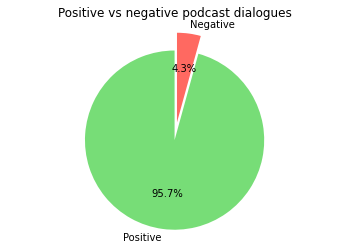

In [37]:
# get total sentiment of dialogues (positive or negative)
def dialogue_sentiments(sentiment_data):
    sentiments = []
    for d in sentiment_data:
        try:
            sentiments.append(mode(d))
        except:
            # in case of equal counts, choose negative
            sentiments.append(0)
    return sentiments  
sents = dialogue_sentiments(data) 

# calculate total counts for positive and negative podcasts
pos_count = sents.count(1)
neg_count = sents.count(0)
print('Total positive podcast episodes:', pos_count)
print('Total negative podcast episodes:', neg_count)


# plot pie chart
labels = 'Positive', 'Negative'
myColors = ((0.467, 0.867, 0.467, 1.0), (1.0, 0.412, 0.38, 1.0))
sizes = [pos_count, neg_count]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, explode=[0.1, 0.1], autopct='%1.1f%%',
        shadow=False, startangle=90, colors = myColors)
ax1.axis('equal')
plt.title('Positive vs negative podcast dialogues')
plt.show()

Below you can see the number and percentage of negative and positive labeled podcast dialogue utterances. As you can see, there exists much more positive utterances than negative ones.

Total positive utterannces: 2201976
Total negative utterances: 808320


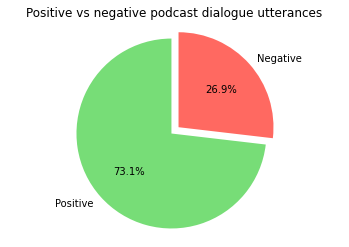

In [38]:
pos_utt_count = [item for sublist in data for item in sublist].count(1)
neg_utt_count = [item for sublist in data for item in sublist].count(0)

print('Total positive utterannces:', pos_utt_count)
print('Total negative utterances:', neg_utt_count)

# plot pie chart
labels = 'Positive', 'Negative'
myColors = ((0.467, 0.867, 0.467, 1.0), (1.0, 0.412, 0.38, 1.0))
sizes = [pos_utt_count, neg_utt_count]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, explode=[0.05, 0.05], autopct='%1.1f%%',
        shadow=False, startangle=90, colors = myColors)
ax1.axis('equal')
plt.title('Positive vs negative podcast dialogue utterances')
plt.show()

The longest negative and postive chain of utterances within a podcast dialogue is shown in the code below.

In [39]:
# get length of longest sequence of positive utterances and longest sequence of negative utterances of a dialogue
def longest_sequence(sentiment_data, sentiment):
    longest = []
    for d in sentiment_data:
        c, max_val = 0, 0
        for s in d: 
            # add to or reset running count
            c = c + 1 if s == sentiment else 0 

            max_val = max([c, max_val]) 
        longest.append(max_val)

    return longest  

longest_pos = max(longest_sequence(data, 1))
longest_neg = max(longest_sequence(data, 0))
print('Longest positive sequence of utterances in a podcast dialogue:', longest_pos)
print('Visualization:', colored(longest_pos * '+', 'green'))
print('Longest negative sequence of utterances in a podcast dialogue:', longest_neg)
print('Visualization:', colored(longest_neg * '-', 'red'))

Longest positive sequence of utterances in a podcast dialogue: 116
Visualization: ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Longest negative sequence of utterances in a podcast dialogue: 32
Visualization: --------------------------------


#### 6.2.2 Sentiment Patterns Found within Podcast Episodes

Several patterns have been mined within dialogues. Below you can see how many times they occur.

In [40]:
# TODO: convert below function to measure percentages within dialogues (what are the most common pattern within a dialogue etc)

In [41]:
# pattern example: +++ = [1, 1, 1], +-+ = [1, 0, 1]
patterns = [[1, 1, 1], [0, 0, 0], [1, 0, 1], [0, 1, 0], [1, 0], [0, 1]]
# Count sentiment patterns within podcasts
def pattern_occurences(sentiment_data, pattern):
  p_counts = []
  for d in sentiment_data:
      c = sum(1 for i in range(len(d)) if d[i:i+len(pattern)]==pattern)
      p_counts.append(c)
  return p_counts

# function to convert bitstring list to a pos/neg string
def sent_list_to_string(l):
  new_l = []
  for item in l:
    if item == 0:
      new_l.append('-')
    else:
      new_l.append('+')
  return ''.join(new_l) 

for pattern in patterns:
  pattern_occ = pattern_occurences(data, pattern)   
  print('Total amounts of pattern {} in podcast episodes: '.format(sent_list_to_string(pattern)), sum(pattern_occ))

Total amounts of pattern +++ in podcast episodes:  1295896
Total amounts of pattern --- in podcast episodes:  134829
Total amounts of pattern +-+ in podcast episodes:  328577
Total amounts of pattern -+- in podcast episodes:  155487
Total amounts of pattern +- in podcast episodes:  500643
Total amounts of pattern -+ in podcast episodes:  500420


Below you can see the gradient of the sentiment of several podcast episodes. The red marked areas represent negative talking, where the green areas represent positive talking. 

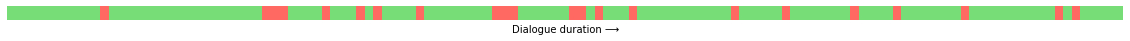

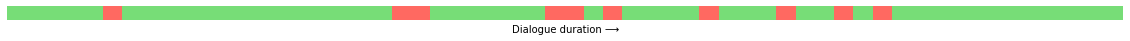

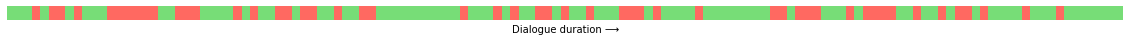

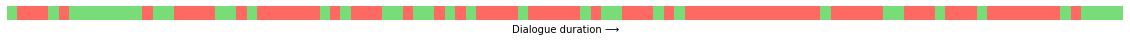

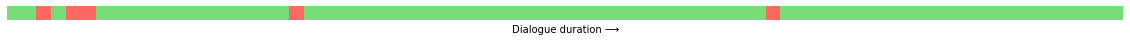

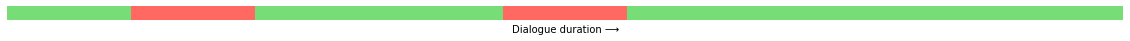

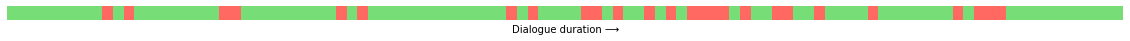

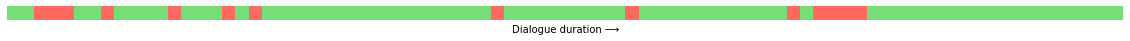

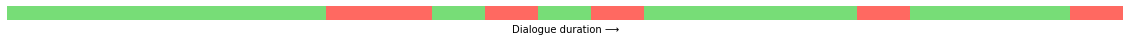

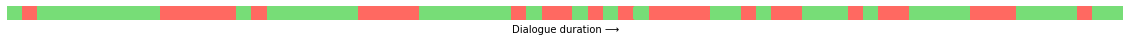

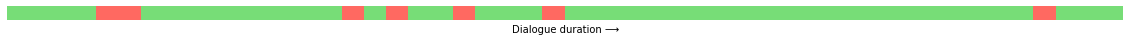

In [42]:
# show a sentimennt visualization of sample at index
def sentiment_progress_visualize(sentiment_data, i):
    x = sentiment_data[i]
    fig, ax = plt.subplots(figsize=(20,0.25))
    ax.set(xlabel=i, ylabel='Episode progress')
    myColors = ((1.0, 0.412, 0.38, 1.0), (0.467, 0.867, 0.467, 1.0))
    cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))          
    seaborn.heatmap([x], square=False, xticklabels=False, yticklabels=False ,cmap=cmap, cbar=False)
    plt.xlabel('Dialogue duration ⟶')
    plt.show()

# visualize
max_v = 10
for i in range(len(data)):
    sentiment_progress_visualize(data, i) 
    if i == max_v:
        break

#### 6.2.3 Sentiment Patterns of Podcast Dialogues in General

In [43]:
# TODO: General patterns

Below you can see the aggregrated sentiment gradient for all podcast episodes in the dataset. Below the gradient, a graph is shown that show the gradient of the sentiment as well, where you can see that the start and end of the dialogue is positive, and most discussion and negative talks occur in the middle of the dialogue.

First the data needs to be scaled using the function described in the Section 5.5.



In [44]:
# scale data
scaled_data = scale_data(data)

# replace 0.0 values with -1.0
scaled_data[scaled_data == 0.0] = -1.0
print('\nData successfully scaled!')

36318it [00:08, 4200.17it/s]



Data successfully scaled!


Then, using the scaled data, the aggregrated sentiment gradient can be visualized below.

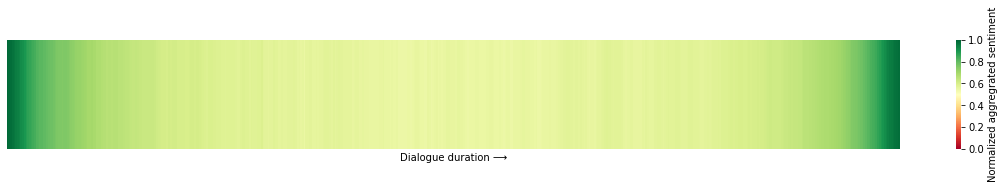

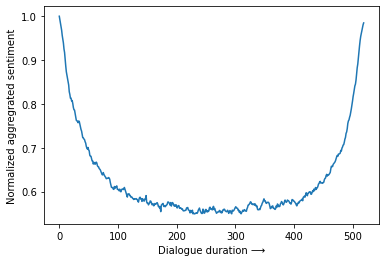

In [45]:
# total sentiment gradient 
summed_scaled_data = np.sum(scaled_data, axis=0)
summed_scaled_data = summed_scaled_data / max(summed_scaled_data)

fig, ax = plt.subplots(figsize=(20,2))
sns = seaborn.heatmap([summed_scaled_data], cmap="RdYlGn", square=False, vmin=0, vmax=1, xticklabels=False, yticklabels=False, cbar=True,  cbar_kws={'label': 'Normalized aggregrated sentiment'})
plt.xlabel('Dialogue duration ⟶')
plt.show()

x = list(range(len(summed_scaled_data)))
plt.plot(x, summed_scaled_data)
plt.ylabel('Normalized aggregrated sentiment')
plt.xlabel('Dialogue duration ⟶')
plt.show()

## 7 Findings




### 7.1 Interpretation

- TODO

### 7.2 Discussion
The one area that could have been most improved upon during this research was the labeled dataset. Due to time constraints, each utterance within this dataset was labeled by only one of three persons. While many of the utterances had a very clear sentiment, there were also cases where it wasn’t very obvious if the sentiment was more positive or negative. Having all utterances labeled by three persons and then deciding by majority vote would have lead to more accurate labels.

Also, while 3012 labeled utterances were certainly enough to make the BERT model learn a certain sense of sentiment in dialogue utterance, having a larger labeled dataset would probably have given better performance in the metrics, especially a better recall.

As an improvement for the K-means method, improvements could include creating a system that automatically appoints the cluster index, and using pre-trained Word2Vec models, as the dataset that is currently being used does not have 100% accurate transcripts, leading to a lot of lost vocabulary.

## 8 Conclusions

### 8.1 Summary
- TODO: Samenvatting + conclusions (inclusief beantwoorden RQs)

### 8.2 Future Work
The performance of the used methods, especially those of the DistilBERT Classifier, show that it is certainly possible to reasonably accurately judge the sentiments of utterances within podcast transcripts. To expand on these findings, much more research in the field of sentiment analysis can be done.

One suggestion for future research is to perform sentiment analysis on written texts other than podcast transcripts. While the Spotify Podcast Dataset contains a very large amount of different podcasts with wildly varying topics and speakers (and speaker styles), all transcripts that were used were still dialogues. Applying these methods to either monologues or texts with more than two speakers might give interesting results.

Another idea for future research is applying sentiment analysis to speech rather than text. Obtaining a sentiment score using features such as pitch, volume and speech rate is a slightly different challenge from what was done here. Moreover, combining speech sentiment analysis with the text sentiment analysis could be a powerful combination. This could also very well be done with the Spotify Podcast Dataset, but was beyond the scope of this project. 

A third and final idea for future research is an extension on the research performed here, namely to see if the sentiment of one speaker throughout a dialogue influences the sentiment of the other speaker. Say one speaker is very positive about a certain subject and one starts off very negatively towards that subject, it would be very interesting to see how frequently it occurs that one of the speakers changes his or her sentiment throughout the dialogue.

## References

